In [30]:
# pip install lexical-diversity, textcomplexity

In [31]:
# импорты
import pandas as pd
import re # для очистки текстовых данных
import matplotlib.pyplot as plt # для графиков
import matplotlib as mpl

import mysql.connector # для работы с sql
from getpass import getpass

import textcomplexity # для анализа текстов
from lexical_diversity import lex_div as ld
import spacy

# Введение
Для лабораторной работы был выбран корпус текстов из журнала "Современник" с 1847 по 1866 годы. Он расположен по ссылке https://dataverse.pushdom.ru/dataset.xhtml?persistentId=doi:10.31860/openlit-2023.11-C006.
В датасет включены очень разнообразные данные. Мы, со своей стороны, в рамках исследования будем использовать не все: для нас интерес представляют таблица формата tsv с метаинформацией по корпусу и сам корпус публикаций.

# Подготовка данных
Начнем с подготовки метаинформации. Поместим ее в пандасовский датафрейм для дальнейшей обработки в питоне.

In [32]:
# указываем путь к таблице
# у меня она лежит в той же директории, к которой подключен юпитер
path = 'publications_metadata.tab'

In [33]:
# откроем с помощью pandas
df = pd.read_csv(path, sep = '\t')
df

,id,uid,author,attribution,signature,signature_index,title,part,translator,dedication,...,censor,volume,number,section_content,section_form,first_page,last_page,length,filename_txt,comments
0,1,4764,Панаев И. И.,установлено,нет,И. И. Панаева,Родственники. Нравственная повесть,1,нет,нет,...,"Ивановский И. А., Куторга С. С.",I,1,Словесность,Словесность,1,69,69,1847_1_1,NaN
1,2,1,Тургенев И. С.,установлено,И. Тургенев,И. С. Тургенева,Деревня («Люблю я вечером к деревне подъезжать...,нет,нет,нет,...,"Ивановский И. А., Куторга С. С.",I,1,Словесность,Словесность,70,76,7,1847_1_2,NaN
2,3,2,Щепкин М. С.,установлено,– – ъ,– – – на,Из записок артиста,нет,нет,нет,...,"Ивановский И. А., Куторга С. С.",I,1,Словесность,Словесность,77,89,13,1847_1_3,NaN
3,4,3,Огарев Н. П.,установлено,Н. Огарев,Н. П. Огарева,«Бываю часто я смущен внутри души...»,нет,нет,нет,...,"Ивановский И. А., Куторга С. С.",I,1,Словесность,Словесность,90,90,1,1847_1_4,NaN
4,5,4,Некрасов Н. А.,установлено,Н. Некрасов,Н. А. Некрасова,Тройка («Что ты жадно глядишь на дорогу...»),нет,нет,И. И. Маслову,...,"Ивановский И. А., Куторга С. С.",I,1,Словесность,Словесность,91,92,2,1847_1_5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,5408,4557,Ватсон Э. К.,установлено,нет,нет,Австрия после 1859 года,нет,нет,нет,...,нет,CXIV,5,Современное обозрение,Современное обозрение,1,28,28,нет,NaN
5408,5409,4558,неизвестный,не установлено,нет,нет,История философии от начала ее в Греции до нас...,нет,нет,нет,...,нет,CXIV,5,Современное обозрение,Современное обозрение,29,37,9,нет,NaN
5409,5410,4559,неизвестный,не установлено,нет,нет,Герберт Спенсер. Собрание сочинений. Издание Н...,нет,нет,нет,...,нет,CXIV,5,Современное обозрение,Современное обозрение,38,41,4,нет,NaN
5410,5411,4560,неизвестный,не установлено,нет,нет,Рассказы из быта раскольничьего. Ив. Шевелкина...,нет,нет,нет,...,нет,CXIV,5,Современное обозрение,Современное обозрение,41,48,8,нет,NaN


Теперь перейдем к подготовке корпуса текстов. 

In [34]:
# укажем путь к папке, в которой лежит корпус
path_to_texts = '/Users/irinakhegay/Downloads/dataverse_files/publications_txt/'

In [35]:
# напишем функцию, которая извлекает текст по названию (filename_txt), заранее обозначенному создателями корпуса
def get_texts_by_filename(filename_txt):
    if filename_txt != 'нет': # условие необходимо, потому что тексты есть не ко всем строчкам датафрейма. для строк со значением "нет" указываем пустые кавычки (прописано ниже)
        path = path_to_texts + filename_txt + '.txt' # склеиваем пути с полными названиями файлов
        with open(path) as file: # открываем файлы
            raw_content = file.read()
            processed_content = raw_content.replace('\n', ' ') # replace нужен для избавления от лишних символов, появляютщихся в процессе чтения
        return processed_content
    else: 
        return ''

In [36]:
# добавляем тексты публикаций в датафрейм
# можно было сразу сделать из них списки с кортежами, но так проще избежать возможных проблем с несоответствием индексов или айди
df['publication_text'] = df['filename_txt'].apply(get_texts_by_filename)
df

,id,uid,author,attribution,signature,signature_index,title,part,translator,dedication,...,volume,number,section_content,section_form,first_page,last_page,length,filename_txt,comments,publication_text
0,1,4764,Панаев И. И.,установлено,нет,И. И. Панаева,Родственники. Нравственная повесть,1,нет,нет,...,I,1,Словесность,Словесность,1,69,69,1847_1_1,NaN,РОДСТВЕННИКИ. НРАВСТВЕННАЯ ПОВѢСіь Родиые люди...
1,2,1,Тургенев И. С.,установлено,И. Тургенев,И. С. Тургенева,Деревня («Люблю я вечером к деревне подъезжать...,нет,нет,нет,...,I,1,Словесность,Словесность,70,76,7,1847_1_2,NaN,ДЕРЕВНЯ. I. Люблю я вечеромъ къ дерево* подъѣз...
2,3,2,Щепкин М. С.,установлено,– – ъ,– – – на,Из записок артиста,нет,нет,нет,...,I,1,Словесность,Словесность,77,89,13,1847_1_3,NaN,"ИЗЪ ЗАПИСОКЪ АРТИСТА Лѣтъ пятьдесятъ назадъ, в..."
3,4,3,Огарев Н. П.,установлено,Н. Огарев,Н. П. Огарева,«Бываю часто я смущен внутри души...»,нет,нет,нет,...,I,1,Словесность,Словесность,90,90,1,1847_1_4,NaN,*» « 1>ываю части я смутенъ внутри души И треп...
4,5,4,Некрасов Н. А.,установлено,Н. Некрасов,Н. А. Некрасова,Тройка («Что ты жадно глядишь на дорогу...»),нет,нет,И. И. Маслову,...,I,1,Словесность,Словесность,91,92,2,1847_1_5,NaN,T I» о и к л. (. И. Маслову.) Что ты жадно гля...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,5408,4557,Ватсон Э. К.,установлено,нет,нет,Австрия после 1859 года,нет,нет,нет,...,CXIV,5,Современное обозрение,Современное обозрение,1,28,28,нет,NaN,
5408,5409,4558,неизвестный,не установлено,нет,нет,История философии от начала ее в Греции до нас...,нет,нет,нет,...,CXIV,5,Современное обозрение,Современное обозрение,29,37,9,нет,NaN,
5409,5410,4559,неизвестный,не установлено,нет,нет,Герберт Спенсер. Собрание сочинений. Издание Н...,нет,нет,нет,...,CXIV,5,Современное обозрение,Современное обозрение,38,41,4,нет,NaN,
5410,5411,4560,неизвестный,не установлено,нет,нет,Рассказы из быта раскольничьего. Ив. Шевелкина...,нет,нет,нет,...,CXIV,5,Современное обозрение,Современное обозрение,41,48,8,нет,NaN,


# Работа с базой данных
Создадим базу данных. 
Для начала сделаем таблицу с метаинформацией и занесем в нее самые интересные для нас столбцы - это id публикации (порядковый номер в таблице), uid (идентификатор, обозначает принадлежность либо непринадлежность к какому-то циклу текстов, может повторяться), author, title, dedication (посвящен ли кому-то текст, если да, то кому), тип (проза или стихи),
year (год публикации), section content (раздел журнала, в который помещена публикация) и length (длина публикации в страницах).
После этого создадим таблицу с самими текстами: в нее войдут id, filename_txt (название файла) и сам publication text.

## Создание БД и первой таблицы с метаданными

In [37]:
# создаем базу данных
mydb = mysql.connector.connect(   # подключаемся
  host = "localhost",
  user = "root",
  password = getpass('Введите ваш пароль!')
)

mycursor = mydb.cursor()  # создаем условный виртуальный курсор
mycursor.execute("CREATE DATABASE sovremennik")  # создаем базу денных

Введите ваш пароль! ········


In [38]:
# готовим данные для импорта в sql - создаем список кортежей
# указываем ind для "закрепления" значения за конкретной строкой, потому что программа в процессе работы пробегается по строкам последовательно
for_meta_db = [(int(df['id'][ind]), int(df['uid'][ind]), df['author'][ind], df['title'][ind], df['dedication'][ind], df['type'][ind], 
                int(df['year'][ind]), df['section_content'][ind], int(df['length'][ind])) for ind in df.index]

In [39]:
# создаем первую пустую таблицу с метаинформацией
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = getpass('Введите ваш пароль!'),
    database = 'sovremennik'
)

mycursor = mydb.cursor()
# тип данных для автора и заголовка - текст, потому что они могут быть очень длинными, и в виде VARCHAR они не принимаются
# для поддержания единообразия датасета наложим ограничение на значения атрибута type 
mycursor.execute("CREATE TABLE metadata (id INT PRIMARY KEY, uid INT, author TEXT, title TEXT, dedication VARCHAR(255), \
    type VARCHAR (5) CHECK (type IN ('проза', 'стихи')), year INT, section VARCHAR (100), length INT)")

Введите ваш пароль! ········


In [40]:
# заполняем таблицу
sql = "INSERT INTO metadata (id, uid, author, title, dedication, type, year, section, length) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
mycursor.executemany(sql, for_meta_db) 
# сохраняем изменения
mydb.commit()

## Работа с запросами
Интересный вышел датасет. Давайте его немного изучим.

Сперва посмотрим, что чаще посвящается кому-то - стихи или проза?

In [41]:
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = getpass('Введите ваш пароль!'),
    database = 'sovremennik'
)
mycursor = mydb.cursor()

# посчитаем, сколько значений "стихи" атрибута type, где указано посвящение кому бы то ни было, есть в таблице
# обозначим выводимый результат как значения столбца poetry - для красоты
sql_poetry = "SELECT COUNT(type) AS poetry FROM metadata WHERE type = 'стихи' AND NOT dedication = 'нет'"
mycursor.execute(sql_poetry)
# положим в кортеж (вернее, список кортежей), чтобы увидеть результат в питоне
poetry_dedicated = mycursor.fetchall() 
poetry_dedicated # выходит 25

Введите ваш пароль! ········


[(25,)]

In [42]:
# проделаем то же самое, но теперь смотрим на значение "проза"
sql_prose = "SELECT COUNT(type) AS prose FROM metadata WHERE type = 'проза' AND NOT dedication = 'нет'"
mycursor.execute(sql_prose)
prose_dedicated = mycursor.fetchall()
prose_dedicated # 80

[(80,)]

Итак, чаще посвящается проза (80 результатов против 25 стихотворных), хотя, возможно, это обусловлено куда большим количеством произаических произведений в датасете. 
Проверим следующим запросом.

In [43]:
# посчитаем, сколько "проз" в целом указано в столбце type в таблице
sql = "SELECT COUNT(type) FROM metadata WHERE type = 'проза'"
mycursor.execute(sql)
prose_overall = mycursor.fetchall()
prose_overall # 4864 

[(4864,)]

Наше предположение оказалось верно - проза занимает 4864 из 5412 строк в базе данных.

Дальше становится любопытно, а в каком цикле из всех больше всего неизвестных авторов? Давайте узнаем.
Прим.: к сожалению, названия циклов неизвестны, скорее всего, их и нет. Они обозначены цифрами (uid).

In [44]:
# выведем uid и количество строк, в которых автор - это неизвестное лицо
# сгруппируем результаты по году
# зададим условие с помощью оператора HAVING для вывода именно тех uid, где неизвестный автор точно повторяется (больше одного такого автора)
# и для наглядности отсортируем по количеству повторяющихся данных
sql = "SELECT uid, COUNT(*) FROM metadata WHERE author = 'неизвестный' GROUP BY uid HAVING COUNT(*) > 1 ORDER BY COUNT(*)"
mycursor.execute(sql)
unknown_cycle = mycursor.fetchall()
unknown_cycle # 4761

[(4760, 2),
 (4684, 2),
 (4693, 2),
 (4800, 2),
 (4790, 2),
 (4810, 2),
 (4606, 2),
 (4596, 3),
 (4796, 4),
 (4761, 6)]

Результат есть - больше всего неизвестных авторов в цикле номер 4761 - их целых 6.

Теперь посмотрим, какая секция самая непопулярная из всех в журнале.

In [45]:
# для этого напишем вложенный запрос
# выберем из таблицы metadata секции, а также подсчитаем и выведем, сколько каких секций повторяется в таблице (=сколько публикаций в каждой секции)
# присвоим отобранным данным alias "amount"
# сгруппируем результат по секции и отсортируем по количеству (по умолчанию сортируется по возрастанию)
# выберем из этого результата единственную строку (в связи с сортировкой первый же результат - самый малочисленный)

sql = "SELECT section FROM (SELECT section, COUNT(section) AS amount FROM metadata GROUP BY section ORDER BY amount ) AS sect LIMIT 1"
mycursor.execute(sql)
unpopular_section = mycursor.fetchall()
unpopular_section # "Хроника военных событий"

[('Хроника военных событий',)]

Получается, что самая непопулярная секция - это "Хроника военных событий".
Комментарий: изначально я пыталась составить более простой запрос наподобие "SELECT MIN(amount) FROM (SELECT section, COUNT(section) AS amount FROM metadata GROUP BY section) AS b)";
но так выдавалось только количество публикаций в секции без указания самой секции. При попытке добавить в первый селект секцию выходила ошибка, связанная с неагрегированными данными. Пришлось шаманить. 
Кроме того, оказалось, что функция TOP для вывода первых рез-тов в моей версии sql не работает, поэтому обходимся LIMIT.

Откровенно говоря, из всего обилия разделов "Современника" лично меня больше всего привлекают "Иностранная литература" и "Науки и хадожества".
Давайте посмотрим, насколько длинные там в среднем выходят публикации?

In [46]:
# выбираем среднюю длину публикаций, входящих в названные разделы
# применяем оператор OR, потому что при использовании AND программа ищет строки, в которых указаны оба раздела сразу
sql = "SELECT AVG (length) FROM metadata WHERE section = 'Иностранная литература' OR section = 'Науки и художества'"
mycursor.execute(sql)
avg_publ_length = mycursor.fetchall()
avg_publ_length # 31.79

[(Decimal('31.7900'),)]

Выходит, что средняя длина публикаций в обоих этих секциях - 31,79 страницы.

Завершим изучение таблицы вот таким вопросом: а какой год был самым продуктивным для "Современника"?

In [47]:
# для этого применим группировку по годам и посчитаем, какие годы чаще всего упоминаются в таблице
# отсортируем результат по убыванию и выведем первую строку
sql = "SELECT year FROM metadata GROUP BY year ORDER BY COUNT(*) DESC LIMIT 1"
mycursor.execute(sql)
productive_year = mycursor.fetchall()
productive_year # 1848

[(1848,)]

Итак, больше всего публикаций в "Современнике" вышло в 1848 году!

## Создание второй таблицы с текстами

In [48]:
# готовим список кортежей для второй таблицы
for_publications_db = [(int(df['id'][ind]), df['filename_txt'][ind], df['publication_text'][ind]) for ind in df.index]

In [49]:
# создаем вторую таблицу с текстами публикаций
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = getpass('Введите ваш пароль!'),
    database = 'sovremennik'
)

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE publications (id INT PRIMARY KEY, file_name VARCHAR (50), text LONGTEXT)")

Введите ваш пароль! ········


In [50]:
# заполняем вторую таблицу
# чтобы избежать проблем с передачей слишком большого пакета данных, передаем все построчно с помощью цикла, а не посредством executemany
sql = "INSERT INTO publications (id, file_name, text) VALUES (%s, %s, %s)"
for i in for_publications_db:
        mycursor.execute(sql, i)
mydb.commit()

In [51]:
# свяжем две таблицы с помощью внешнего ключа id
mycursor.execute("ALTER TABLE publications ADD FOREIGN KEY (id) REFERENCES metadata(id)")
mydb.commit()

# Исследование
Поставим следующую цель: проанализировать эволюцию (или ее отсутствие) текстов по годам с использованием двух метрик: TTR и средней длины предложения.
Для этого сначала выгрузим тексты публикаций, посчитаем соответствующие метрики и создадим для них третью таблицу в БД.

In [52]:
# выгружаем тексты публикаций
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = getpass('Введите ваш пароль!'),
    database = 'sovremennik'
)

mycursor = mydb.cursor()
sql = "SELECT text FROM publications"
mycursor.execute(sql)
all_texts_tuples = mycursor.fetchall()

Введите ваш пароль! ········


In [53]:
# переменная all_texts_tuples - это список кортежей
# для удобной работы нам надо вытащить тексты из кортежей и объединить их в один список
all_texts = []
for tuple in all_texts_tuples:
    for text in tuple: 
        all_texts.append(text)

In [54]:
# all_texts[0]

In [55]:
# посчитаем ttr
ttrs = []
counter = 1
for text in all_texts:
    tokenized_text = ld.tokenize(text)
    tokenized_text_ttr = round(ld.mattr(tokenized_text), 2)
    ttrs.append([counter, tokenized_text_ttr])
    counter += 1

In [56]:
# а теперь среднюю длину предложений (в словах)
# для этого нужно посчитать длину текста (в словах-токенах) и разделить ее на количество предложений

avg_sent_length = []
counter = 1

for text in all_texts:
    tokenized_text = ld.tokenize(text)
    text_length = len(tokenized_text)

    sentences = re.split(r'(?<=\!|\.)[ \n]', text)
    sentences_amount = len(sentences)

    average_sent_length = round(text_length / sentences_amount, 2)
    avg_sent_length.append([average_sent_length, counter])
    counter += 1

In [57]:
# сравним на всякий случай длину списков, чтобы удостовериться, что она одинаковая
len(ttrs)

5412

In [58]:
len(avg_sent_length)

5412

In [59]:
# создадим в базе данных таблицу с полученными данными по ttr
mycursor.execute("CREATE TABLE analytics (id INT PRIMARY KEY, ttr FLOAT (5))")
sql = "INSERT INTO analytics (id, ttr) VALUES (%s, %s)"
mycursor.executemany(sql, ttrs) 
mydb.commit()

In [60]:
# свяжем таблицу с таблицей с метаданными
mycursor.execute("ALTER TABLE analytics ADD FOREIGN KEY (id) REFERENCES metadata(id)")
mydb.commit()

Упс! Совсем забыли про столбец с длиной предложения. Добавим и заполним его отдельно.

In [61]:
mycursor.execute("ALTER TABLE analytics ADD avg_sent_length FLOAT (5)")
mydb.commit()

In [62]:
# заполняем новый столбец
sql = 'UPDATE analytics SET avg_sent_length = %s WHERE id = %s'

mycursor.executemany(sql, avg_sent_length)
mydb.commit()

Теперь у нас есть три таблички: с метаданными, текстами публикаций и аналитикой. Попробуем совместить аналитику с годами из первой таблицы, чтобы получить данные по годам.

In [63]:
mycursor = mydb.cursor(buffered=True) # добавляем параметр, чтобы избежать внутренней ошибки

mycursor.execute("SELECT a.id, a.ttr, a.avg_sent_length, m.year FROM analytics AS a LEFT OUTER JOIN metadata AS m ON a.id = m.id")
myresult = mycursor.fetchall()
mydb.commit() 

In [64]:
# смотрим, что получилось
myresult[0]

(1, 0.89, 15.38, 1847)

Все готово для создания графика.

In [65]:
# закинем в отдельный список ttr
ttrs_list = []
for tuple_element in myresult:
    ttrs = tuple_element[1]
    ttrs_list.append(ttrs)

In [66]:
# повторим для avg_sent_length
sent_length_list = []
for tuple_element in myresult:
    avg_sent_lengths = tuple_element[2]
    sent_length_list.append(avg_sent_lengths)

In [67]:
# и для годов
years_list = []
for tuple_element in myresult:
    years = tuple_element[3]
    years_list.append(years)

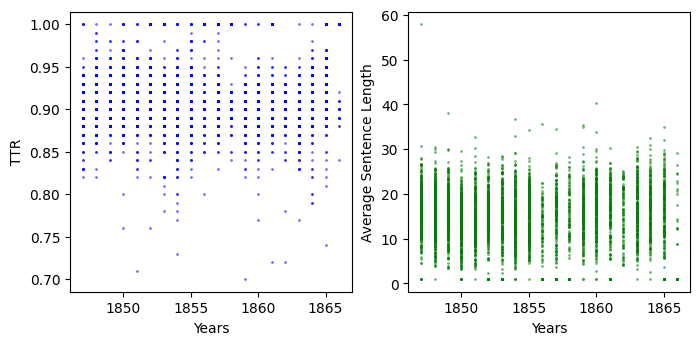

In [68]:
# строим график
x = years_list
y_1 = ttrs_list
y_2 = sent_length_list

plt.figure(figsize=(8, 8))

plt.subplot(2,2,1)
plt.xlabel('Years')
plt.ylabel('TTR')
plt.scatter(x, y_1, c ="blue", linewidths = 0.5, s = 2, alpha=0.5)

plt.subplot(2,2,2)
plt.xlabel('Years')
plt.ylabel('Average Sentence Length')
plt.scatter(x, y_2, c ="green", linewidths = 0.5, s = 2, alpha=0.5)

Мы видим, что как таковых резких изменений в данных по выбранным метрикам не было: что лексическое разнообразие, что длина предложений публикаций в "Современнике" остаются примерно одинаковыми, а выбросы разбросаны по годом и, скорее всего, зависят не времени написания или публикации.

Давайте посмотрим, что это за аномальные произведения и кем они были написаны.

In [69]:
# выведем названия и авторов публикаций, в которых ттр меньше 0.8 
mycursor = mydb.cursor()
sql_ttr = "SELECT id, title, author FROM metadata WHERE id IN (SELECT id FROM analytics WHERE ttr < 0.8)"
mycursor.execute(sql_ttr)
ttr_anomalies = mycursor.fetchall()
# ttr_anomalies

In [70]:
# выведем названия и авторов публикаций, в которых средняя длина предложения выше 30 
sql_sent_length = "SELECT id, title, author FROM metadata WHERE id IN (SELECT id FROM analytics WHERE avg_sent_length > 30)"
mycursor.execute(sql_sent_length)
sent_length_anomalies = mycursor.fetchall()
# sent_length_anomalies

Теперь посмотрим, есть ли между ними пересечения. Для этого создадим и заполним две новые таблицы на основании полученных выше данных.

In [71]:
# первая с аномальными ttr
mycursor.execute("CREATE TABLE ttr_anomaly (id INT PRIMARY KEY, title VARCHAR(1000), author VARCHAR(1000))")
sql = "INSERT INTO ttr_anomaly (id, title, author) VALUES (%s, %s, %s)"
mycursor.executemany(sql, ttr_anomalies) 
mydb.commit()

In [72]:
# вторая с аномальной длиной
mycursor.execute("CREATE TABLE sent_length_anomaly (id INT PRIMARY KEY, title VARCHAR(1000), author VARCHAR(1000))")

sql = "INSERT INTO sent_length_anomaly (id, title, author) VALUES (%s, %s, %s)"
mycursor.executemany(sql, sent_length_anomalies) 
mydb.commit()

In [73]:
mycursor.execute("ALTER TABLE ttr_anomaly ADD FOREIGN KEY (id) REFERENCES analytics(id)") 
mydb.commit()

In [74]:
mycursor.execute("ALTER TABLE sent_length_anomaly ADD FOREIGN KEY (id) REFERENCES analytics(id)") 
mydb.commit()

In [75]:
# сделаем INNER JOIN, чтобы вывести дупликаты в обеих таблицах
sql = "SELECT ta.author FROM ttr_anomaly AS ta INNER JOIN sent_length_anomaly AS sla ON ta.title = sla.title" # уточним, каких авторов мы выбираем, чтобы не сбивать БД с толку
mycursor.execute(sql)
intersections = mycursor.fetchall()
intersections # пустой список 

[]

Как мы видим, в результате наш список ничем не заполнился - подходяших результатов не нашлось. 
Таким образом, совпадений в двух таблицах нет, а значит, мы не можем обосновать выбросы в данных стилистикой конкретных авторов.

# Отвлеченный вопрос
Наш предыдущий график - это точечная диаграмма, и это логично: визуализировать такие данные иначе не получается. Но сможем ли мы по-новому взглянуть на результаты, если усреднить их и сделать кривую? К примеру, начнем с TTR. Для этого сгруппируем данные по годам и возьмем средний показатель TTR по годам.

In [76]:
# мы не записывали запрос с аналитикой и годами в отдельную таблицу... сделаем это сейчас.
# создадим таблицу по селекту
mycursor = mydb.cursor()
sql = "CREATE TABLE analytics_joined AS SELECT a.id, a.ttr, a.avg_sent_length, m.year FROM analytics AS a LEFT OUTER JOIN metadata AS m ON a.id = m.id" 
mycursor.execute(sql)
mydb.commit()

In [77]:
# сгруппируем ее по годам и выведем в список кортежей показатели TTR (округленные до 3 знаков после запятой) и соответствующий год
sql_ttr = "SELECT ROUND(AVG(ttr), 3), year FROM analytics_joined GROUP BY year"
mycursor.execute(sql_ttr)
avg_ttr = mycursor.fetchall()
# avg_ttr

In [78]:
# повторим для второй таблицы
sql_sent = "SELECT ROUND(AVG(avg_sent_length), 3), year FROM analytics_joined GROUP BY year"
mycursor.execute(sql_sent)
avg_sent = mycursor.fetchall()
# avg_sent

In [79]:
# вновь занесем данные в разные списки для графика
ttrs_ind = []
for element in avg_ttr:
    ttr = element[0]
    ttrs_ind.append(ttr)

length_ind = []
for element in avg_sent:
    length = element[0]
    length_ind.append(length)

In [80]:
# годы совпадают в обоих списках, так что их заполним только один раз
years_all = []
for elem in avg_ttr: # можно подставить и avg_sent
    year = elem[1]
    years_all.append(year)

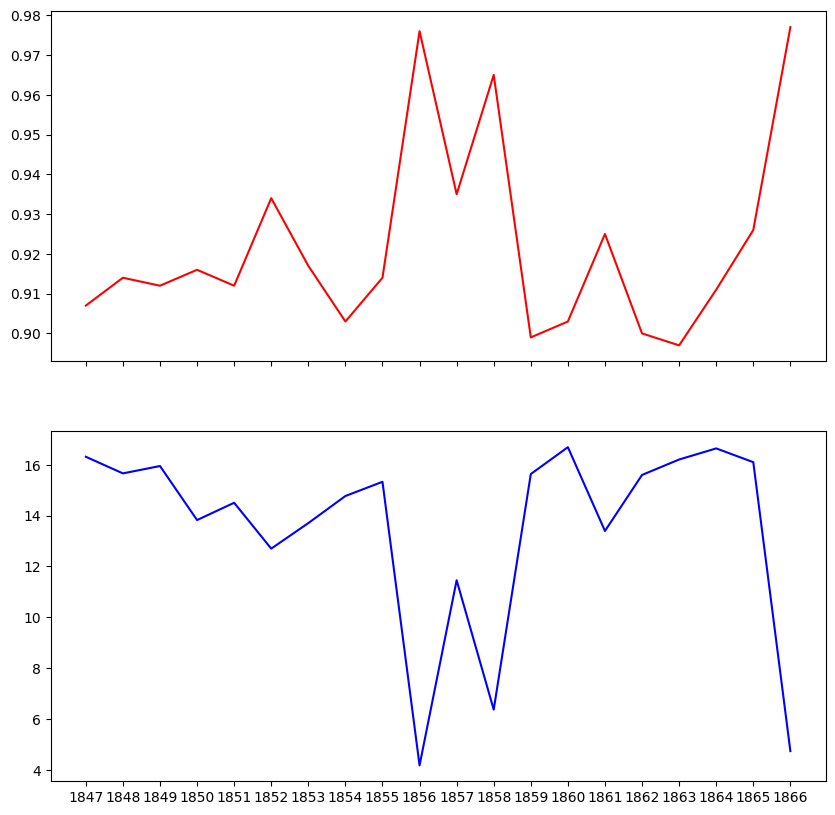

In [81]:
# построим новый график

x = years_all
y = ttrs_ind
z = length_ind

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10),  sharex=True) # ось x совпадает для обоих сабплотов
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True)) # годы автоматически отражаются как float, вернем им тип int
ax1.set_xticks(ticks = x)

ax1.plot(x, y, color='r', label='TTR')
ax2.plot(x, z, color='b', label='Sent')

plt.show()

Теперь все выглядит более интригующе. 
Мы видим на первом графике острые углы, особенно резкие взлеты и падения наблюдаются в промежутке между 1855 и 1859 годами. Ниже всего средний TTR падает в 1863 году, а потом стремительно поднимается наверх. 
Второй более равномерен: "проседания" происходят где-то с 1855 по 1858 годы, сильное падение демонстрируется в 1865 году. Хотя при этом в целом разлом выглядит почти зеркально на обоих графиках. С чем это могло бы быть связано? Для этого потребуются дальнейшие, более глубокие исследования.

In [82]:
mycursor.close()

True